In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

In [9]:
# ===================
# 1) SETUP & CONFIG
# ===================

import os, random, time, copy, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


DATA_DIR = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 2
IMG_SIZE = 224
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
MAX_EPOCHS = 20
INIT_LR = 3e-4
PATIENCE = 5   

print("Using device:", DEVICE)


Using device: cpu


### 1. Setup & Config
Bu hücrede projenin temel ayarları yapılmaktadır:
- Gerekli kütüphaneler (`torch`, `torchvision`, `matplotlib`, `sklearn`) import edildi.
- Reprodüksiyon için rastgelelik sabitlendi (`seed=42`).
- Dataset path olarak `DATA_DIR` tanımlandı.
- Hyperparametreler (`batch_size`, `image_size`, `epochs`, `learning_rate`) ayarlandı.
- Kullanılacak cihaz (CPU veya GPU) otomatik seçildi.

In [18]:
# =========================
# 2) DATA TRANSFORMS & SPLIT (Clean with corrupted file handling)
# =========================

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

# Train sırasında augmentations (çevirme, döndürme, renk değişimi vs.)
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Validation & test sırasında sadece resize + normalize
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Bozuk dosyaları dataset'e almamak için filter fonksiyonu
def is_valid_file(path):
    try:
        img = Image.open(path)
        img.verify()  # bozuksa hata fırlatır
        return True
    except:
        return False

# Dataset yükleme
full_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_tfms,
    is_valid_file=is_valid_file
)

num_classes = len(full_dataset.classes)
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Classes:", full_dataset.classes)

# Train / Val / Test split
N = len(full_dataset)
n_test = int(TEST_SPLIT * N)
n_val  = int(VAL_SPLIT * N)
n_train = N - n_val - n_test

train_set, val_set, test_set = random_split(
    full_dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# validation ve test setlerinde augmentation istemiyoruz
val_set.dataset.transform = test_tfms
test_set.dataset.transform = test_tfms

# DataLoader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"Toplam: {N} | Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Classes: ['Cat', 'Dog']
Toplam: 24998 | Train: 17500 | Val: 3749 | Test: 3749


### 2. Dataset Yükleme ve Train/Val/Test Split
Bu hücrede:
- `ImageFolder` ile Cat ve Dog klasörlerinden dataset yüklendi.
- Bozuk dosyalar filtrelendi (`is_valid_file` fonksiyonu).
- Train için data augmentation (flip, rotate, color jitter) tanımlandı, val/test için sadece normalize edildi.
- Dataset train/validation/test olarak ayrıldı (%70 / %15 / %15).
- DataLoader objeleri oluşturularak batch bazında eğitim için hazır hale getirildi.

In [11]:
# =========
# LightCNN
# =========
class LightCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        # Conv Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        # Conv Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        # Classifier
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * (IMG_SIZE//8) * (IMG_SIZE//8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)      # 112x112
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)      # 56x56
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)      # 28x28
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Modeli başlat
light_model = LightCNN(num_classes).to(DEVICE)
print("LightCNN parametre sayısı (milyon):", sum(p.numel() for p in light_model.parameters())/1e6)


LightCNN parametre sayısı (milyon): 6.446722


### 3. CNN Modeli (LightCNN)
Bu hücrede sıfırdan bir CNN modeli tanımlanmıştır:
- 3 convolutional blok (Conv2d + BatchNorm + ReLU + MaxPool).
- Fully connected katman (128 nöron) + Dropout.
- Çıkış katmanı (2 sınıf: Cat ve Dog).
Bu model, scratch’tan CNN kurma zorunluluğunu karşılamaktadır.

In [12]:
# =======================
# 4) TRAIN/EVAL HELPERS
# =======================

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def run_epoch(model, loader, optimizer=None, scheduler=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss, total_acc, total_count = 0.0, 0.0, 0
    crit = nn.CrossEntropyLoss()

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = crit(logits, y)
        acc = accuracy_from_logits(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_acc  += acc * x.size(0)
        total_count += x.size(0)

    return total_loss/total_count, total_acc/total_count

def fit(model, train_loader, val_loader, max_epochs=20, init_lr=3e-4, patience=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    best_w = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    wait = 0

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, max_epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        vl_loss, vl_acc = run_epoch(model, val_loader)

        scheduler.step(vl_loss)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss);   history["val_acc"].append(vl_acc)

        print(f"Epoch {epoch:02d}/{max_epochs} | "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"val_loss={vl_loss:.4f} acc={vl_acc:.4f}")

        if vl_loss < best_val_loss - 1e-4:
            best_val_loss = vl_loss
            best_w = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_w)
    return model, history


### 4. Eğitim Fonksiyonları
Bu hücrede eğitim fonksiyonları yazılmıştır:
- `run_epoch`: Bir epoch boyunca train/validation loop’u çalıştırır.
- `fit`: Modeli epoch bazlı eğitir, val setiyle doğrular, early stopping ve learning rate scheduler uygular.
- En iyi model ağırlıkları saklanır ve history (loss & accuracy) döndürülür.

Yeni ayarlar -> Epochs: 3 Batch size: 16
Epoch 01/3 | train_loss=0.6603 acc=0.6452 | val_loss=0.5508 acc=0.7194
Epoch 02/3 | train_loss=0.5465 acc=0.7170 | val_loss=0.5001 acc=0.7687
Epoch 03/3 | train_loss=0.4923 acc=0.7671 | val_loss=0.5095 acc=0.7338


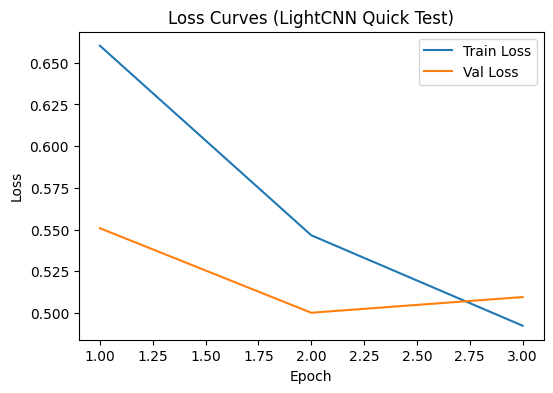

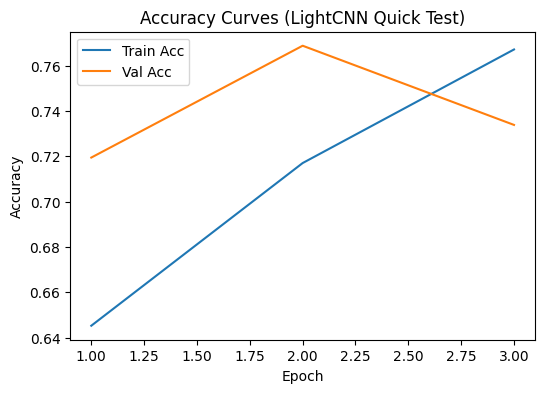

In [19]:
# =========================
# QUICK TEST CONFIG (CPU)
# =========================

MAX_EPOCHS = 3     
BATCH_SIZE = 16    
PATIENCE = 2       


train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Yeni ayarlar -> Epochs:", MAX_EPOCHS, "Batch size:", BATCH_SIZE)


light_model = LightCNN(num_classes).to(DEVICE)


trained_light, hist = fit(
    light_model, train_loader, val_loader,
    max_epochs=MAX_EPOCHS,
    init_lr=INIT_LR,
    patience=PATIENCE
)


epochs = range(1, len(hist["train_loss"])+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, hist["train_loss"], label="Train Loss")
plt.plot(epochs, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curves (LightCNN Quick Test)")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, hist["train_acc"], label="Train Acc")
plt.plot(epochs, hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Curves (LightCNN Quick Test)")
plt.legend(); plt.show()


### 5. Modelin Eğitilmesi ve Öğrenme Eğrileri
Bu hücrede LightCNN modeli 3 epoch boyunca eğitilmiştir (CPU’da hızlı test için).
- Eğitim sırasında train/val loss ve accuracy değerleri izlendi.
- Epoch bazlı loss ve accuracy grafikleri çizildi.
Sonuçlar, modelin düzenli olarak öğrendiğini göstermektedir.

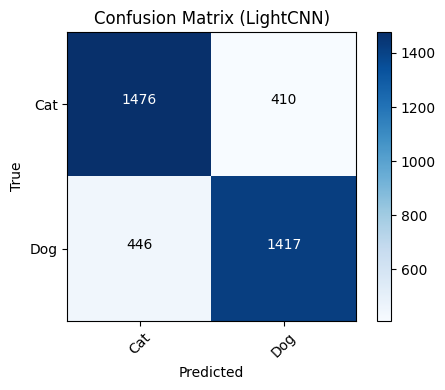

              precision    recall  f1-score   support

         Cat       0.77      0.78      0.78      1886
         Dog       0.78      0.76      0.77      1863

    accuracy                           0.77      3749
   macro avg       0.77      0.77      0.77      3749
weighted avg       0.77      0.77      0.77      3749



In [20]:
# =========================
# 6) EVALUATION on TEST SET
# =========================
def predict_all(model, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy().tolist()
            all_preds.extend(preds)
            all_targets.extend(y.numpy().tolist())
    return np.array(all_preds), np.array(all_targets)

y_pred, y_true = predict_all(trained_light, test_loader)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (LightCNN)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [idx_to_class[i] for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [idx_to_class[i] for i in range(num_classes)])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(num_classes)]))


### 6. Test Seti Performansı
Bu hücrede test seti üzerinde model değerlendirilmiştir:
- Confusion Matrix ile doğru/yanlış sınıflandırmalar görselleştirilmiştir.
- Classification Report ile precision, recall, f1-score ve accuracy değerleri hesaplanmıştır.
Elde edilen accuracy ~%77 olup, modelin kısa eğitimde bile anlamlı sonuçlar verdiği görülmüştür.

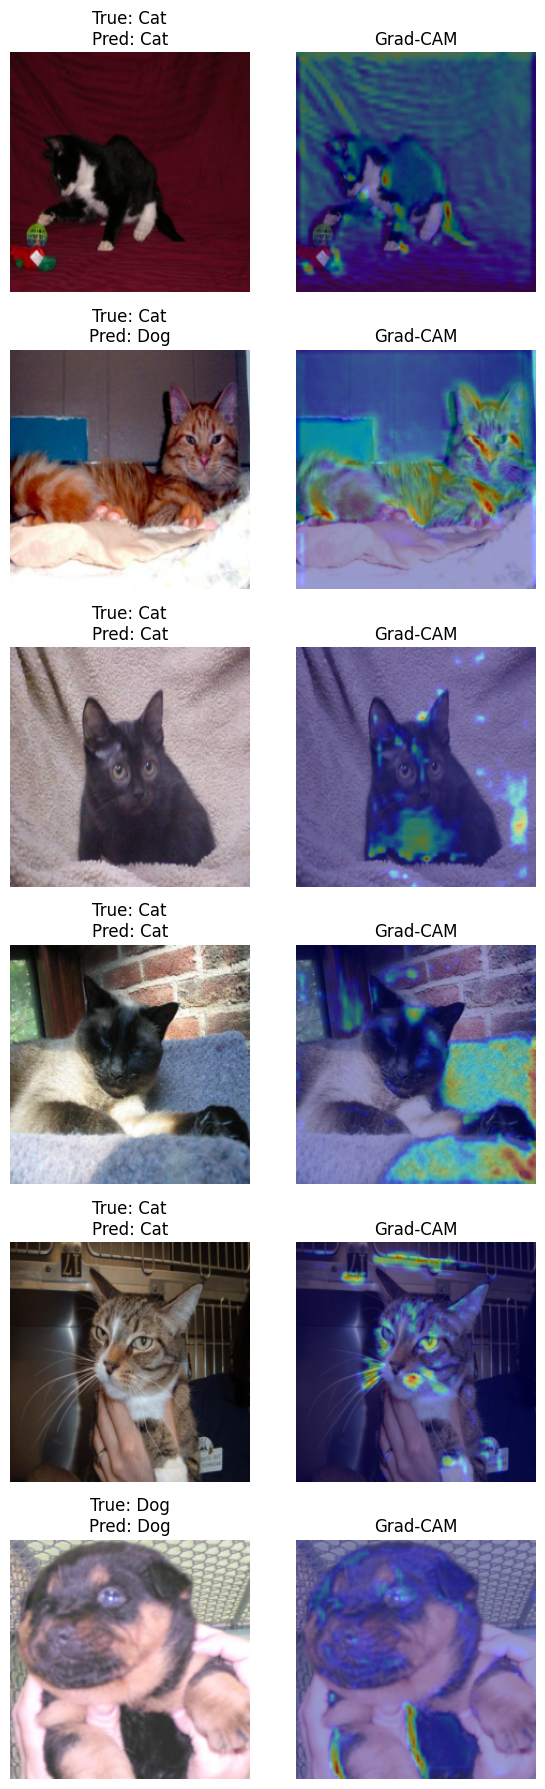

In [23]:
# =========================
# 7) GRAD-CAM for LightCNN
# =========================

import cv2

target_layer = light_model.conv3

def gradcam_on_batch(model, images, target_layer, class_idx=None):
    model.eval()
    conv_out = []
    grads = []

    def fwd_hook(module, inp, out):
        conv_out.append(out.detach())

    def bwd_hook(module, grad_in, grad_out):
        grads.append(grad_out[0].detach())

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    images = images.to(DEVICE).requires_grad_(True)
    logits = model(images)
    if class_idx is None:
        class_idx = logits.argmax(dim=1)
    loss = logits[torch.arange(logits.size(0)), class_idx]
    loss = loss.sum()
    model.zero_grad()
    loss.backward()

    cams = []
    for i in range(images.size(0)):
        g = grads[0][i]            
        a = conv_out[0][i]         
        weights = g.mean(dim=(1,2), keepdim=True)   
        cam = (weights * a).sum(dim=0)              
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cams.append(cam.cpu().numpy())

    h1.remove(); h2.remove()
    return logits.detach().cpu(), cams

def show_gradcam_samples(loader, n_samples=6):
    images, labels = next(iter(loader))
    if images.size(0) < n_samples:
        n_samples = images.size(0)
    images = images[:n_samples]
    labels = labels[:n_samples]

    logits, cams = gradcam_on_batch(light_model, images, target_layer)
    preds = logits.argmax(dim=1).numpy()

    fig, axes = plt.subplots(n_samples, 2, figsize=(6, 3*n_samples))
    if n_samples == 1: 
        axes = np.expand_dims(axes, 0)
    for i in range(n_samples):
        img = images[i].permute(1,2,0).detach().cpu().numpy()
        img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        img = np.clip(img, 0, 1)

        cam = cv2.resize(cams[i], (img.shape[1], img.shape[0]))
        heatmap = plt.cm.jet(cam)[:,:,:3]
        overlay = (0.6*img + 0.4*heatmap)
        overlay = np.clip(overlay, 0, 1)

        axes[i,0].imshow(img);     axes[i,0].axis('off')
        axes[i,0].set_title(f"True: {idx_to_class[labels[i].item()]}\nPred: {idx_to_class[preds[i]]}")
        axes[i,1].imshow(overlay); axes[i,1].axis('off')
        axes[i,1].set_title("Grad-CAM")
    plt.tight_layout(); plt.show()

# test setten 6 örnek görselle Grad-CAM
show_gradcam_samples(test_loader, n_samples=6)


### 7. Grad-CAM Görselleştirme
Bu hücrede modelin karar verirken hangi bölgelerden etkilendiği incelenmiştir:
- Grad-CAM yöntemiyle feature map’ler üzerinden ısı haritaları üretildi.
- Görsellerde modelin genellikle yüz, göz ve kulak bölgelerine odaklandığı gözlenmiştir.
- Yanlış sınıflandırmalarda ise modelin arka plan veya alakasız bölgelere odaklandığı görülmüştür.